<a href="https://colab.research.google.com/github/AlejandroPinto5/EDA-projects/blob/main/NYC-taxi-project/EDA_taxi_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**EDA NYC taxi trip duration**



In [18]:
#Importing libraries
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [10]:
#Reading Dataset
df = pd.read_csv('drive/MyDrive/nyc_taxi_trip_duration.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [12]:
#Checking NaN Values
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [13]:
#Checking info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


###Reformatting features & Checking consistency
There are a variety of features within the dataset and it is important to convert them into the right format such that we can analyse them easily. This would include converting datetime features and string features.

Also, one important thing is never to take assumptions without backing it with data. Here, as you can see the trip duration can also be calculated pick up and drop off datetime. We will check whether the given duration is consistent with the calculated trip duration

In [14]:
# converting strings to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

# Converting yes/no flag to 1 and 0
df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

df['check_trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).map(lambda x: x.total_seconds())

duration_difference = df[np.abs(df['check_trip_duration'].values  - df['trip_duration'].values) > 1]
duration_difference.shape

(0, 12)

In [17]:
#Checking stats in hoursfor target variable
df['trip_duration'].describe()/3600

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

There is a trip with duration of 538 hours. This is a huge outlier and might create problems at the prediction stage. One idea is to log transform the trip duration before prediction to visualise it better.

<Axes: xlabel='log_trip_duration'>

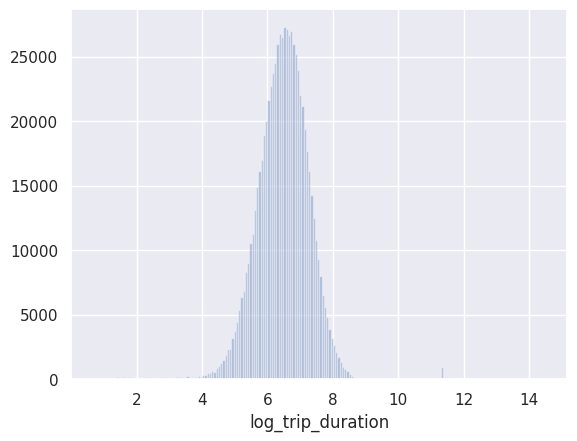

In [21]:
df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)
sb.set()
sb.distplot(df['log_trip_duration'], kde = False, bins = 200)

We find:

1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.

##Univariate Visualization
First of all, let us look at some of the binary features. Looking at each feature might uncover some insight that might be useful at later modelling stages

<Axes: xlabel='passenger_count', ylabel='count'>

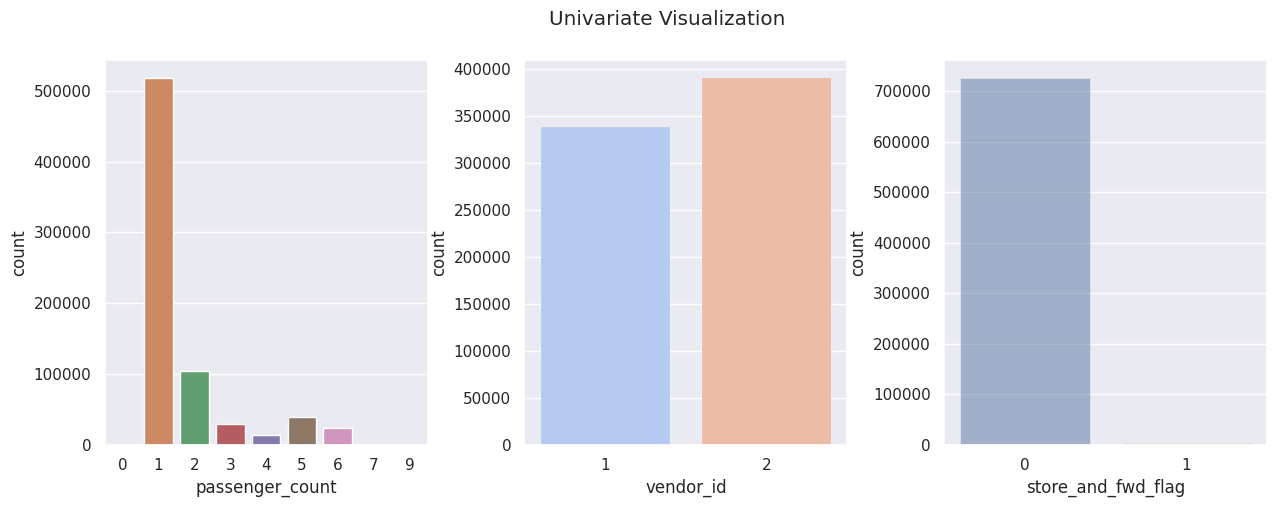

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False, gridspec_kw={'wspace': 0.3})
fig.suptitle('Univariate Visualization')
sb.set()

sb.countplot(data=df,ax=axes[2],x="store_and_fwd_flag",
           fill="blue", 
           linewidth=0.5, alpha=.5)

sb.countplot(data=df,ax=axes[1], x="vendor_id",
           fill=True, 
           palette="coolwarm", linewidth=0.1)

sb.countplot(data=df,ax=axes[0],x="passenger_count")


**Observations:**
1. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers, but they are very low in number.
2. Vendor 2 has more number of trips as compared to vendor 1
3. The store_and_fwd_flag values, indicating whether the trip data was sent immediately to the vendor (“0”) or held in the memory of the taxi because there was no connection to the server (“1”), show that there was almost no storing taking place

In [42]:
# delve into the datetime features to understand the trend of number of hourly/monthly/daily taxi trips
df['pickup_datetime'].min(), df['pickup_datetime'].max()

(Timestamp('2016-01-01 00:01:14'), Timestamp('2016-06-30 23:59:37'))

Clearly, These trips are for first 6 months of 2016. To look at trends, we first need to extract week days and hour of day from the pickup date.

<Axes: xlabel='hour_of_day', ylabel='count'>

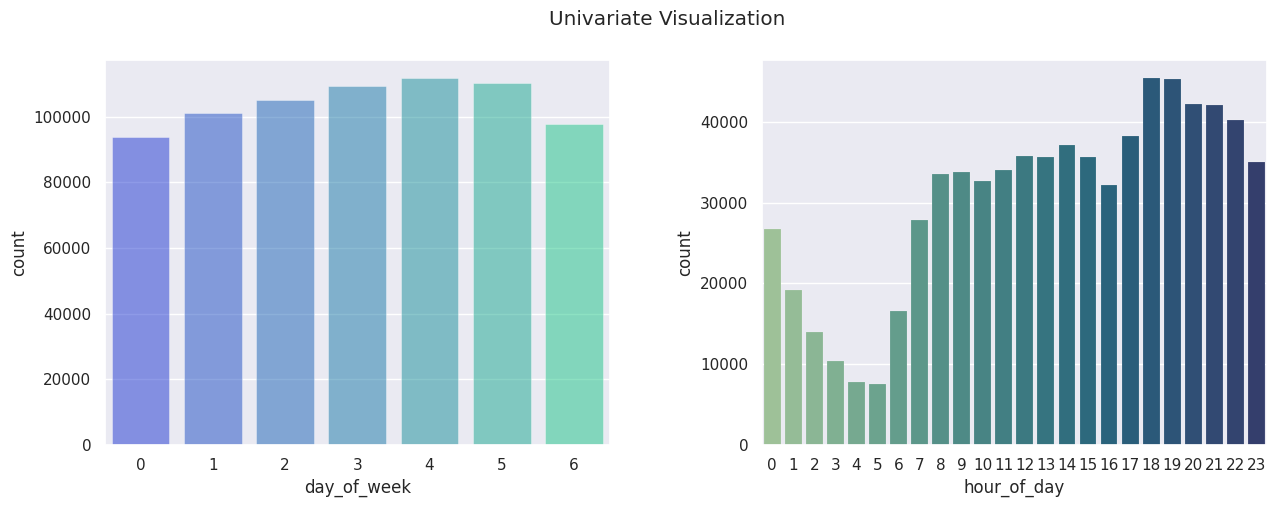

In [51]:
df['day_of_week'] = df['pickup_datetime'].dt.weekday
df['hour_of_day'] = df['pickup_datetime'].dt.hour


fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False, gridspec_kw={'wspace': 0.3})
fig.suptitle('Univariate Visualization')
sb.set()

sb.countplot(data=df,ax=axes[0],x="day_of_week",
           fill="blue", palette = "winter",
           linewidth=0.5, alpha=.5)

sb.countplot(data=df,ax=axes[1], x="hour_of_day",
           fill=True, 
           palette="crest", linewidth=0.1)

* Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
* Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.

### Lattitude & Longitude
Lets look at the geospatial or location features to check consistency. They should not vary much as we are only considering trips within New York city.


<Axes: ylabel='Density'>

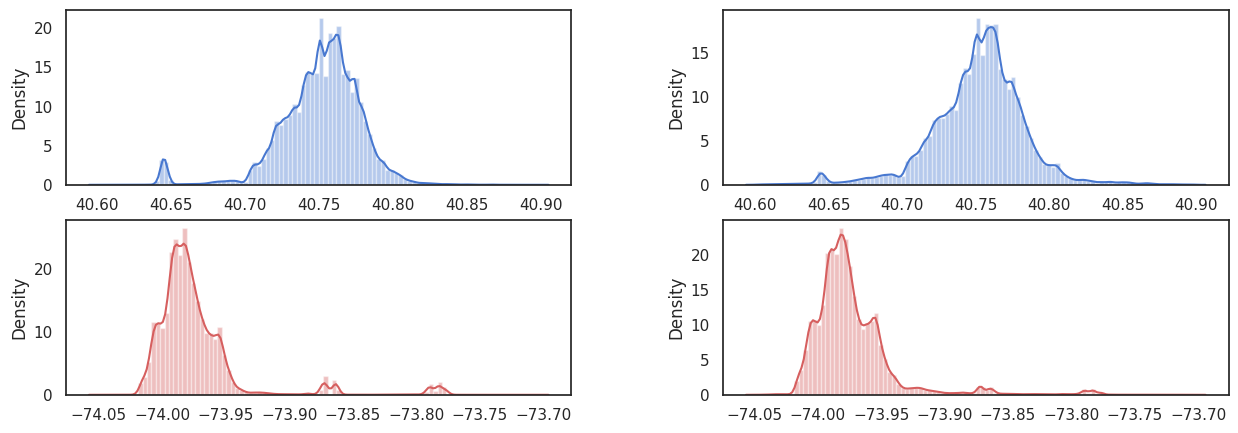

In [61]:
# remove these outliers and look at the distribution more closely
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_data_new = df.copy()

sb.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(15, 5), sharex=False, sharey = False, gridspec_kw={'wspace': 0.3})
# sb.despine(left=True)
sb.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sb.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
sb.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
sb.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
# plt.setp(axes, yticks=[])
# plt.tight_layout()
# plt.show()

* We have a much better view of the distribution of coordinates instead of spikes. And we see that most trips are concentrated on these lat longs, with only a few significant clusters.
* These clusters are represented by the numerous peaks in the latitude and longitude histograms

##**Bivariate Relations with Target**
For different week days, the trip durations can vary as different week days might have different traffic densities especially the weekends might have a much different patterns as compared to working days. Weekday is taken as a decimal number, where 0 - Sunday and 6 is Saturday.

<Axes: xlabel='hour_of_day', ylabel='trip_duration'>

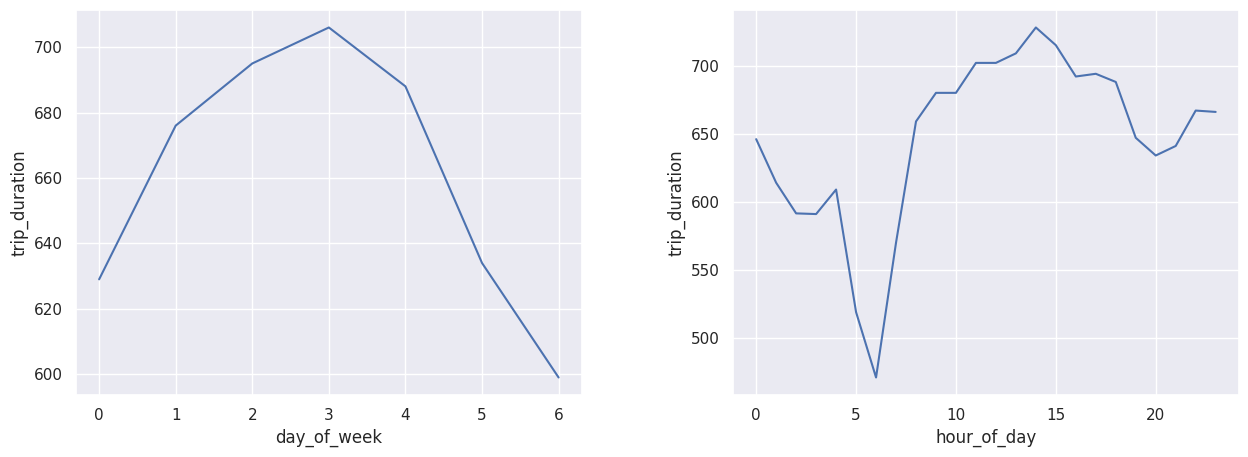

In [71]:
# Trip duration vs Weekday
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1


summary_hourly_avg_duration = pd.DataFrame(df.groupby(['hour_of_day'])['trip_duration'].median())
summary_hourly_avg_duration.reset_index(inplace = True)
summary_hourly_avg_duration['unit']=1


sb.set(color_codes=True)
f, axes = plt.subplots(1,2,figsize=(15, 5), sharex=False, sharey = False, gridspec_kw={'wspace': 0.3})

sb.lineplot(data=summary_wdays_avg_duration, x="day_of_week", hue= "unit", y="trip_duration", ax=axes[0], legend = False)
sb.lineplot(data=summary_hourly_avg_duration, x="hour_of_day", hue= "unit", y="trip_duration",ax = axes[1], legend = False)





* Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
* It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration

<Axes: xlabel='vendor_id', ylabel='trip_duration'>

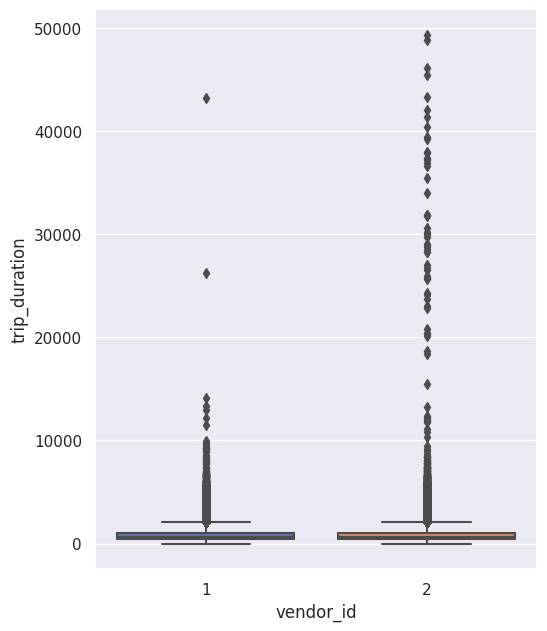

In [80]:
# vendor_id vs Trip Duration
df_sub = df[df['trip_duration'] < 50000] # Remove the huge outliers
sb.set(rc={'figure.figsize':(5.7,7.27)})
sb.boxplot(x="vendor_id", y="trip_duration", data=df_sub)


As you can see, we were in a false perception earlier that vendor 1 had more outliers. Since the median is just around 600 seconds, we observe that vendor 2 has many more outliers as compared to vendor 1. Next, to confirm this, we will quickly look at the mean wrt day of week for both vendors using tsplot (time series plot) from seaborn.

<Axes: xlabel='day_of_week', ylabel='trip_duration'>

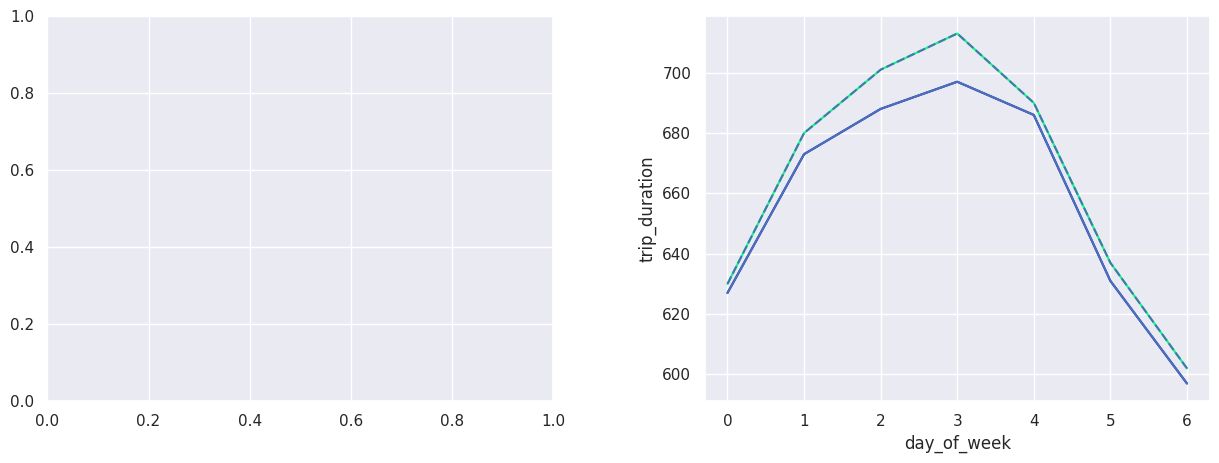

In [90]:
# Mean Median Trip duration Vendor Wise

summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sb.set(color_codes=True)
f, axes = plt.subplots(1,2,figsize=(15, 5), sharex=False, gridspec_kw={'wspace': 0.3})

sb.lineplot(data=summary_wdays_avg_duration, x="day_of_week", style = "unit", hue="vendor_id", y="trip_duration", legend = False, palette = "winter")
sb.lineplot(data=summary_wdays_avg_duration, x="day_of_week", hue = "unit", style="vendor_id", y="trip_duration", legend = False)


Median trip duration does not vary much as can be seen from the above plot for different vendors. It emphasises the importance of looking at the correct measure for central tendency for analysis.

<Axes: xlabel='passenger_count', ylabel='trip_duration'>

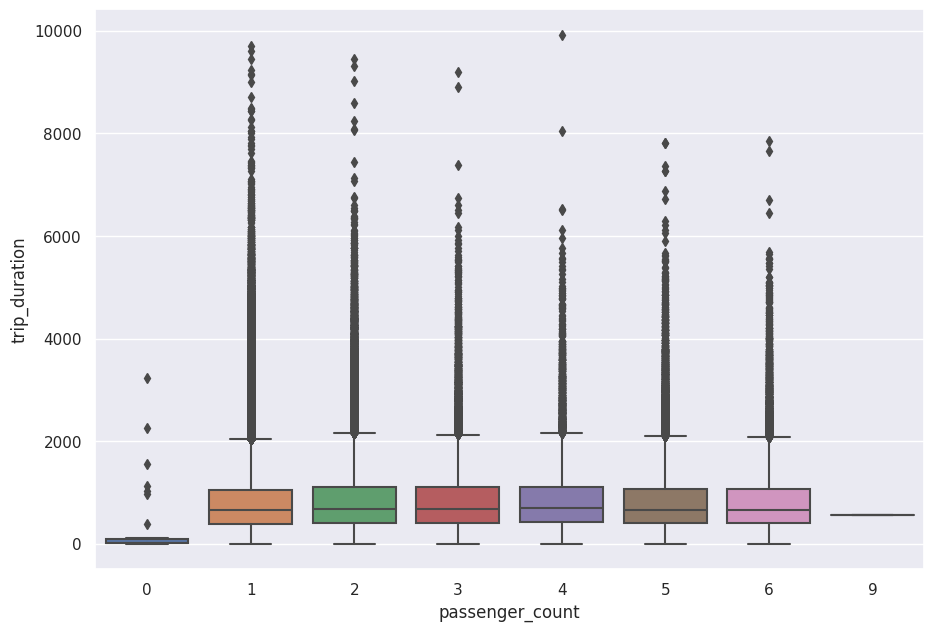

In [92]:
# Trip Duration vs Passenger Count
df.passenger_count.value_counts()
df_sub = df[df['trip_duration'] < 10000] # Removing huge outliers

sb.set(rc={'figure.figsize':(10.7,7.27)})
sb.boxplot(x="passenger_count", y="trip_duration", data=df_sub)

* The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
* Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.

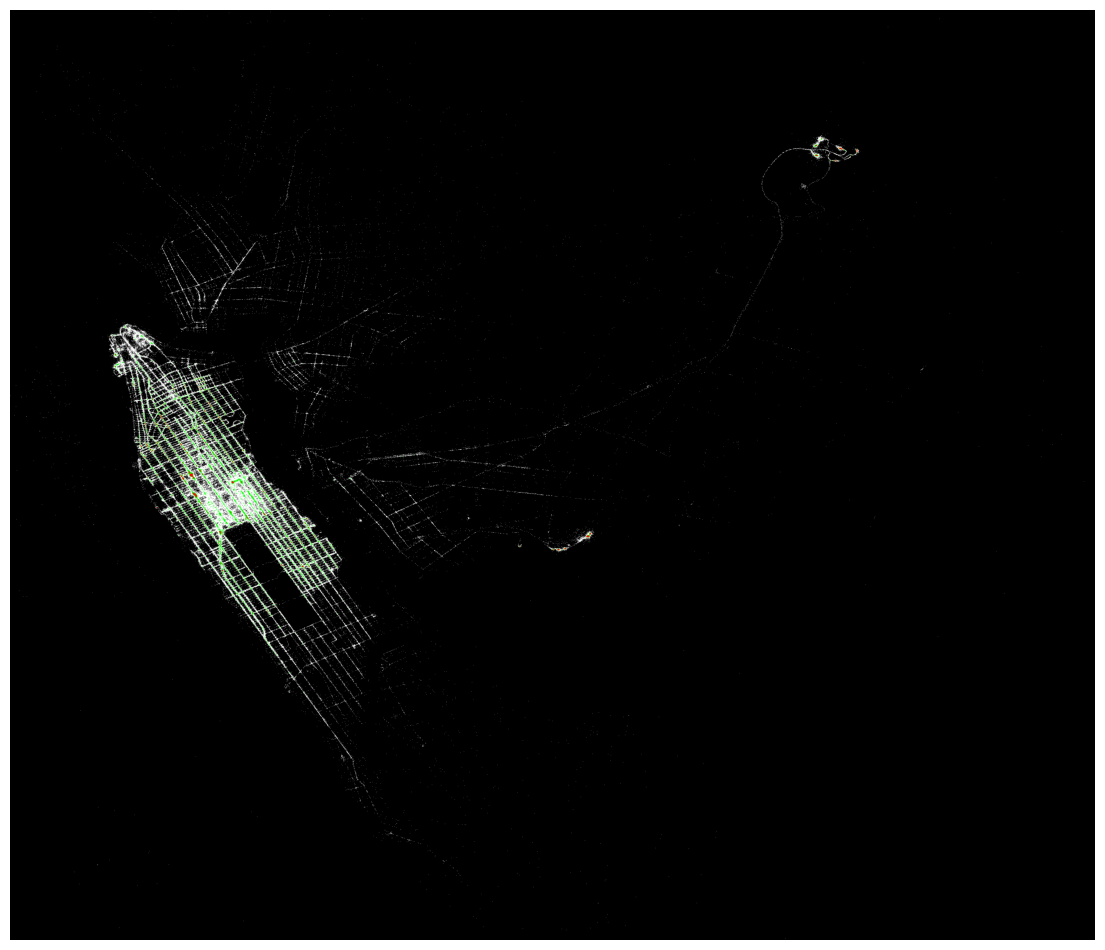

In [93]:
# Visualise most frequently occuring Pickup points on the lattitude-longitude Map

rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
df_data_new['pick_lat_new'] = list(map(int, (df['pickup_latitude'] - (40.6000))*10000))
df_data_new['drop_lat_new'] = list(map(int, (df['dropoff_latitude'] - (40.6000))*10000))
df_data_new['pick_lon_new'] = list(map(int, (df['pickup_longitude'] - (-74.050))*10000))
df_data_new['drop_lon_new'] = list(map(int,(df['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(df_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//25) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 255
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

Findings - From the heatmap kind of image above -

* White points - 1-10 trips have white as pickup point
* Green points - 10-25 trips have green as pickup point
* Red points - More than 25 trips have red as pickup point

As expected there are a few small clusters for hot pickup points as displayed by red in the above plot. Most pickup points have less than 10 trips and distributed all over the city.

If you go and have a look at an actual map of New York City, red and green points are mostly concentrated around the Manhatten Area

<Axes: >

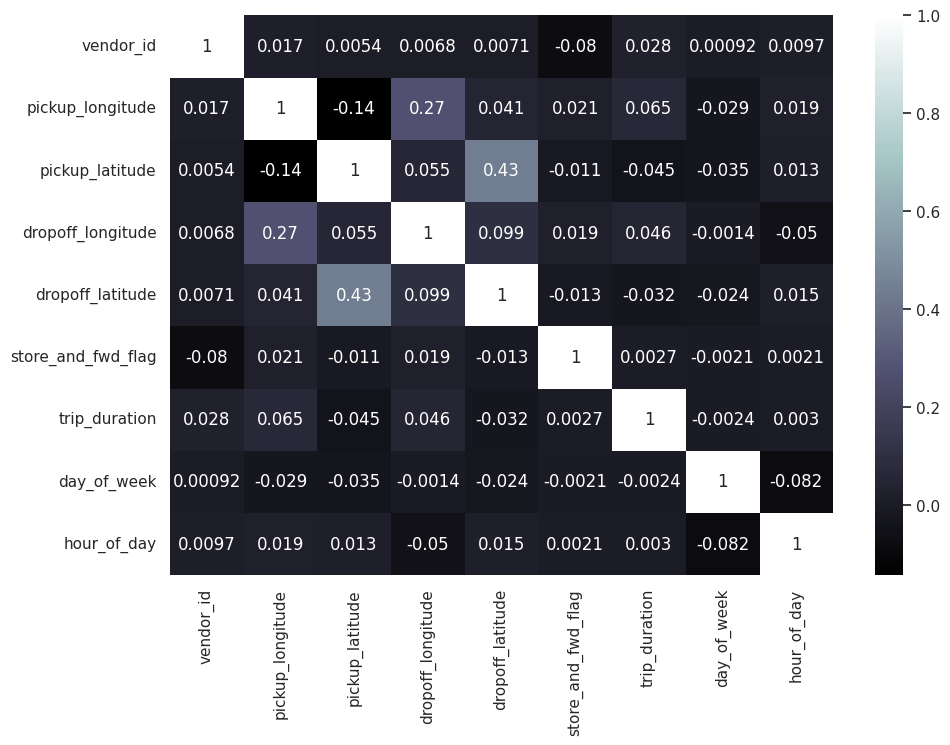

In [102]:
#Correlation map
sb.set()
correlacion = df.corr()
correlacion
sb.heatmap(correlacion,xticklabels=correlacion.columns,yticklabels=correlacion.columns,annot=True, cmap = "bone")
     

### Conclusions
1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.
4. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
5. Vendor 2 has more number of trips as compared to vendor 1
6. Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
7. Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.
8. We see that most trips are concentrated between these lat long only with a few significant clusters. These clusters are represented by the numerous peaks in the lattitude and longitude histograms
9. Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
10. It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration
11. Median trip duration does not vary much as can be seen from the above plot for different vendors.
12. The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
13. Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.
14. From the correlation heatmap we see that the lattitude and longitude features have higher correlation with the target as compared to the other features.